# Install libraries (offline)

In [24]:
%%capture
!pip install ../input/segmentation-models-wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/timm-0.3.2-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/segmentation_models_pytorch-0.1.3-py3-none-any.whl

# Import Dependencies

In [25]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings("ignore")


def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
fix_all_seeds(2021)


# Define constants and load df

In [26]:
SAMPLE_SUBMISSION  = '../input/sartorius-cell-instance-segmentation/sample_submission.csv'
TRAIN_CSV = "../input/sartorius-cell-instance-segmentation/train.csv"
TRAIN_PATH = "../input/sartorius-cell-instance-segmentation/train"
TEST_PATH = "../input/sartorius-cell-instance-segmentation/test"

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

# (336, 336)
IMAGE_RESIZE = (224, 224)

LEARNING_RATE = 5e-4
EPOCHS = 12

In [27]:
df_train = pd.read_csv(TRAIN_CSV)
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


# Training Dataset and Dataloader

## Utilities

In [28]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

## Dataset and Dataloader

In [29]:
class CellDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.base_path = TRAIN_PATH
        self.transforms = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5),
                                   ToTensorV2()])
        self.gb = self.df.groupby('id')
        self.image_ids = df.id.unique().tolist()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)
        annotations = df['annotation'].tolist()
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)
        mask = build_masks(df_train, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))

    def __len__(self):
        return len(self.image_ids)

In [30]:
ds_train = CellDataset(df_train)
image, mask = ds_train[1]
image.shape, mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

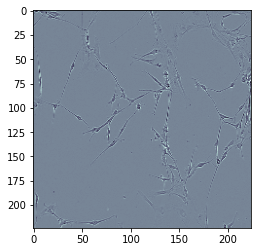

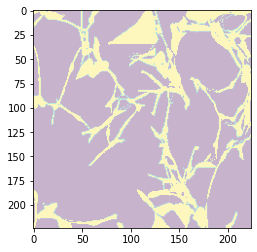

In [31]:
plt.imshow(image[0], cmap='bone')
plt.show()
plt.imshow(mask[0], alpha=0.3)
plt.show()

In [32]:
dl_train = DataLoader(ds_train, batch_size=64, num_workers=4, pin_memory=True, shuffle=False)

In [33]:
len(dl_train)

10

In [34]:
# get a batch from the dataloader
batch = next(iter(dl_train))
images, masks = batch

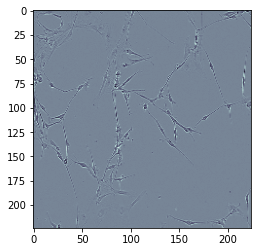

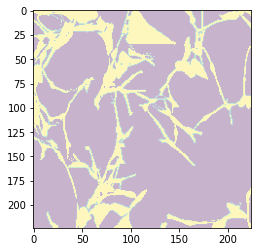

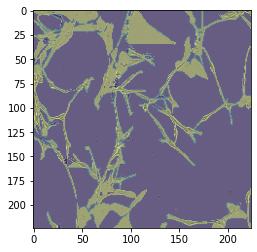

In [35]:
idx=1
plt.imshow(images[idx][0], cmap='bone')
plt.show()
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()

# Losses

In [36]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [37]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/pytorch-pretrained-image-models/resnet34.pth /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth

import torch
import collections.abc as container_abcs
torch._six.container_abcs = container_abcs
import segmentation_models_pytorch as smp

# U-Net

In [38]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

# Training loop

No validation or k-folds for now, just get it running for few epochs.

In [39]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(dl_train)

model.cuda()
model.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(dl_train):
        
        # Predict
        images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

Starting epoch: 1 / 12
Epoch: 1 - Train Loss 3.7909
Starting epoch: 2 / 12
Epoch: 2 - Train Loss 2.2725
Starting epoch: 3 / 12
Epoch: 3 - Train Loss 1.9335
Starting epoch: 4 / 12
Epoch: 4 - Train Loss 1.7761
Starting epoch: 5 / 12
Epoch: 5 - Train Loss 1.6735
Starting epoch: 6 / 12
Epoch: 6 - Train Loss 1.6028
Starting epoch: 7 / 12
Epoch: 7 - Train Loss 1.5530
Starting epoch: 8 / 12
Epoch: 8 - Train Loss 1.5035
Starting epoch: 9 / 12
Epoch: 9 - Train Loss 1.4533
Starting epoch: 10 / 12
Epoch: 10 - Train Loss 1.4178
Starting epoch: 11 / 12
Epoch: 11 - Train Loss 1.4871
Starting epoch: 12 / 12
Epoch: 12 - Train Loss 1.5086


# Predict

## Test Dataset and DataLoader

In [40]:
class TestCellDataset(Dataset):
    def __init__(self):
        self.test_path = TEST_PATH
        
        # I am not sure if they adapt the sample submission csv or only the test folder
        # I am using the test folders as the ground truth for the images to predict, which should be always right
        # The sample csv is ignored
        self.image_ids = [f[:-4]for f in os.listdir(self.test_path)]
        self.num_samples = len(self.image_ids)
        self.transform = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), ToTensorV2()])

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        path = os.path.join(self.test_path, image_id + ".png")
        image = cv2.imread(path)
        image = self.transform(image=image)['image']
        return {'image': image, 'id': image_id}

    def __len__(self):
        return self.num_samples

In [41]:
del dl_train, ds_train, optimizer

In [42]:
ds_test = TestCellDataset()
dl_test = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

## Postprocessing: separate different components of the prediction mask

### Utilities

In [43]:
def post_process(probability, threshold=0.5, min_size=300):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = []
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            a_prediction = np.zeros((520, 704), np.float32)
            a_prediction[p] = 1
            predictions.append(a_prediction)
    return predictions

# Stolen from: https://www.kaggle.com/arunamenon/cell-instance-segmentation-unet-eda
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# Modified by me
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [44]:
pd.read_csv(SAMPLE_SUBMISSION)

,id,predicted
0,7ae19de7bc2a,NaN
1,d48ec7815252,NaN
2,d8bfd1dafdc4,NaN


In [45]:
def check_is_run_length(mask_rle):
    if not mask_rle:
        return True
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    start_prev = starts[0]
    ok = True
    for start in starts[1:]:
        ok = ok and start > start_prev
        start_prev = start
        if not ok:
            return False
    return True

def create_empty_submission():
    fs = os.listdir("../input/sartorius-cell-instance-segmentation/test")
    df = pd.DataFrame([(f[:-4], "") for f in fs], columns=['id', 'predicted'])
    df.to_csv("submission.csv", index=False)

### Predict & submit

In [46]:
model.eval()

submission = []
for i, batch in enumerate(tqdm(dl_test)):
    preds = torch.sigmoid(model(batch['image'].cuda()))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for image_id, probability_mask in zip(batch['id'], preds):
        try:
            #if probability_mask.shape != IMAGE_RESIZE:
            #    probability_mask = cv2.resize(probability_mask, dsize=IMAGE_RESIZE, interpolation=cv2.INTER_LINEAR)
            probability_mask = cv2.resize(probability_mask, dsize=(704, 520), interpolation=cv2.INTER_LINEAR)
            predictions = post_process(probability_mask)
            for prediction in predictions:
                #plt.imshow(prediction)
                #plt.show()
                try:
                    submission.append((image_id, rle_encoding(prediction)))
                except:
                    print("Error in RL encoding")
        except Exception as e:
            print(f"Exception for img: {image_id}: {e}")
        
        # Fill images with no predictions
        image_ids = [image_id for image_id, preds in submission]
        if image_id not in image_ids:
            submission.append((image_id, ""))
            
df_submission = pd.DataFrame(submission, columns=['id', 'predicted'])
df_submission.to_csv('submission.csv', index=False)

if df_submission['predicted'].apply(check_is_run_length).mean() != 1:
    print("Check run lenght failed")
    create_empty_submission()

  0%|          | 0/1 [00:00<?, ?it/s]